In [1]:
# Import all necessary libraries for this example

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import seaborn as sns
import h5py
import DCCSMLM

%matplotlib notebook

In [2]:
# Using SMAP, you will have to generate separate files for the color channels
mVenus_filename = "ExampleData/20190429_8b_cam1_sml.mat"
mCherry_filename = "ExampleData/20190429_8c_cam1_sml.mat"

raw_data = DCCSMLM.DCCSMLM() # Initialize an empty DCCSMLM object

# Load an example mVenus recording from the .mat file, asssign channel ID 0
raw_data.load_channel(mVenus_filename, channel_id="mVenus")

# Load the corresponding example PAmCherry recording from the same file as above, assign channel ID 1.
# Automatically correct the CA using the parameters stored in the "CA_parameters.csv" file.
raw_data.load_channel(mCherry_filename, channel_id="mCherry", ca_file="ExampleData/CA_parameters.csv")


<IPython.core.display.Javascript object>


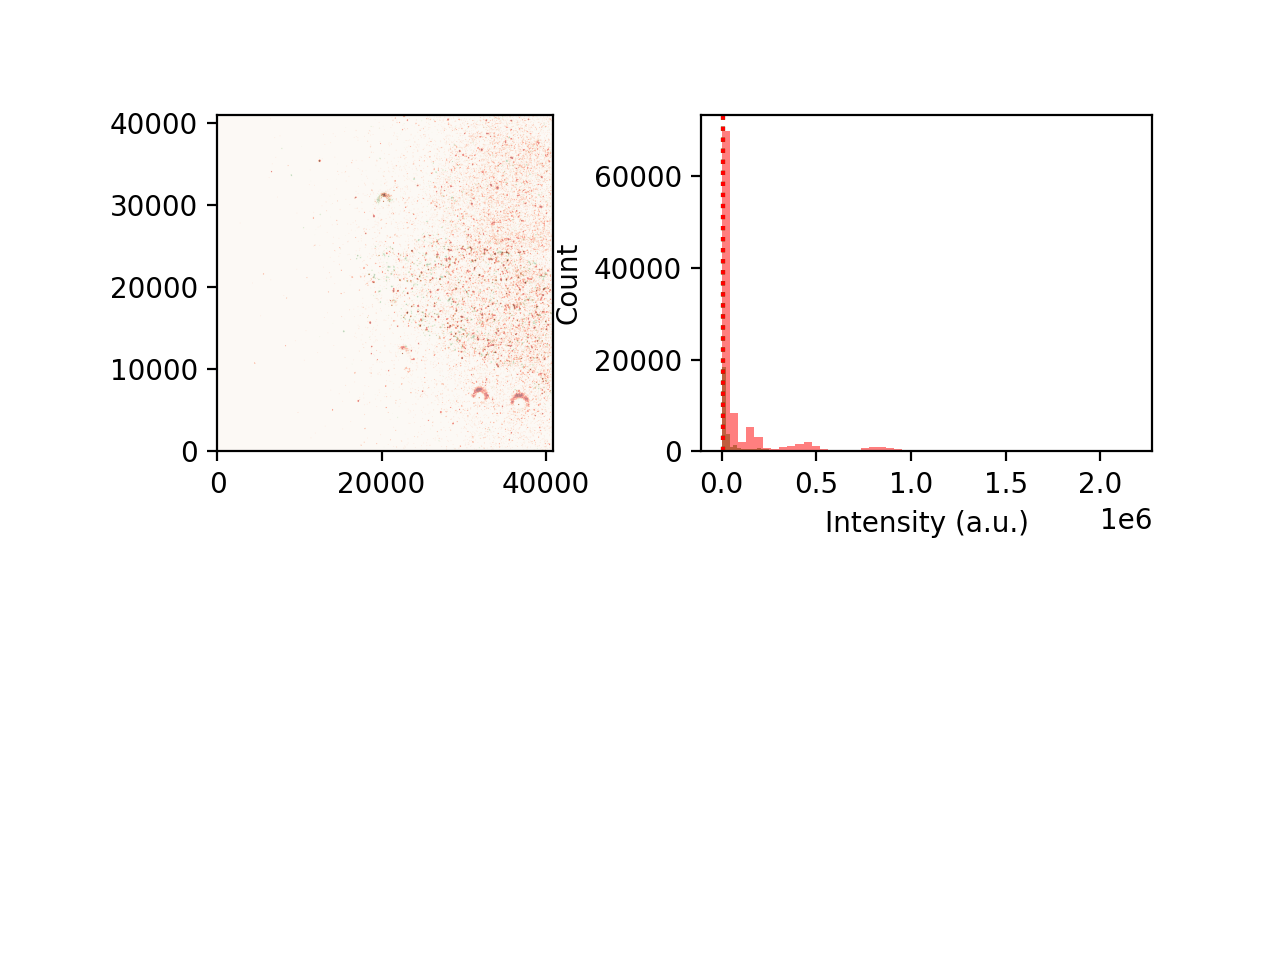

In [3]:
# Create an overview over the localizations in the file
plt.subplot(221)

# Create the reconstructions (images) of the localizations of each channel
mVenus_reconstruction = raw_data.channel["mVenus"].generate_reconstruction()
PAmCherry_reconstruction = raw_data.channel["mCherry"].generate_reconstruction()

# Plot the reconstructions
imgplot = plt.imshow(mVenus_reconstruction, cmap="Greens", alpha=0.5, extent=[0,40960,0,40960])
imgplot = plt.imshow(PAmCherry_reconstruction, cmap="Reds", alpha=0.5, extent=[0,40960,0,40960])


# Create and plot a histogram of the intensities of the localizations in the cluster. Fiducial markers (beads)
# typically have higher fluroescence than the fluorescent proteins used in our example. Identification of
# beads can thus be performed by only considering signals with an intensity > 100 for mVenus and > 65 for PAmCherry.
intensity_column = raw_data.channel["mVenus"].intensity_column # The name of the column can be different for SNSMIL or SMAP data

plt.subplot(222)
plt.hist(raw_data.channel["mVenus"].raw_data[intensity_column], color="green", alpha=0.5, bins=50)
plt.hist(raw_data.channel["mCherry"].raw_data[intensity_column], color="red", alpha=0.5, bins=50)
plt.axvline(10_000, color="green", ls=":")
plt.axvline(10_000, color="red", ls=":")
plt.xlabel("Intensity (a.u.)")
plt.ylabel("Count")

plt.show()

In [4]:
# Find the fiducial markers (beads) based on the intensity_thresholds determined above
mVenus_beads = raw_data.channel["mVenus"].find_clusters(intensity_threshold=10_000, min_samples=500, eps=100) 
PAmCherry_beads = raw_data.channel["mCherry"].find_clusters(intensity_threshold=10_000, min_samples=500, eps=100) 




<IPython.core.display.Javascript object>


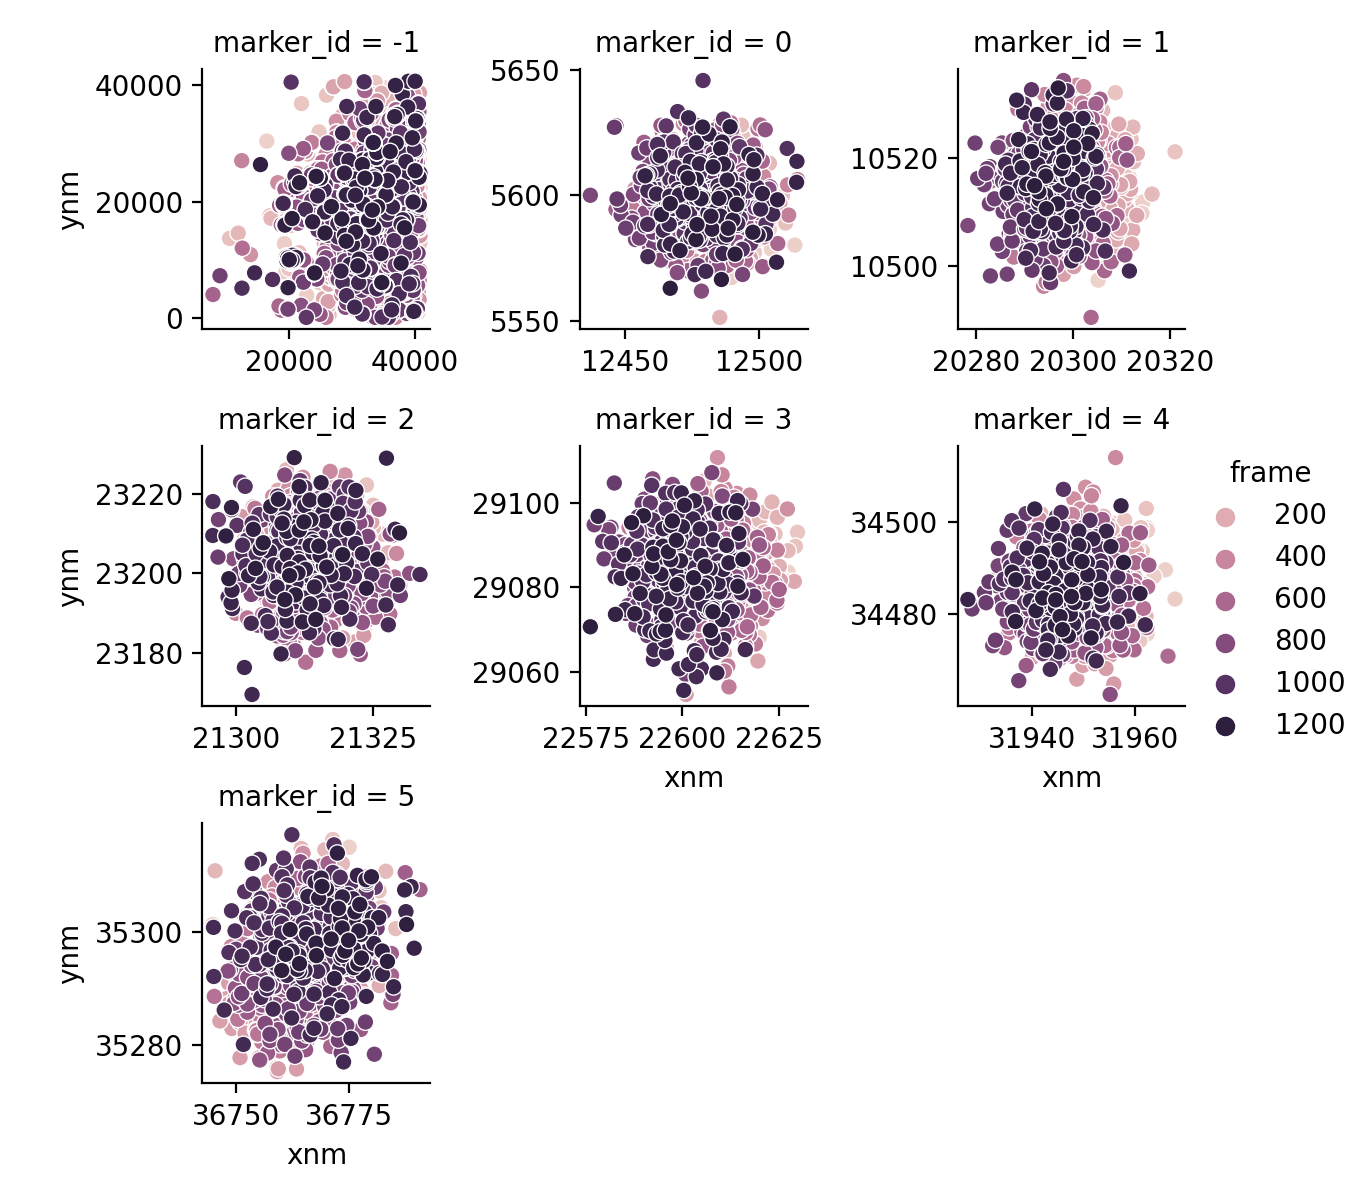

<IPython.core.display.Javascript object>


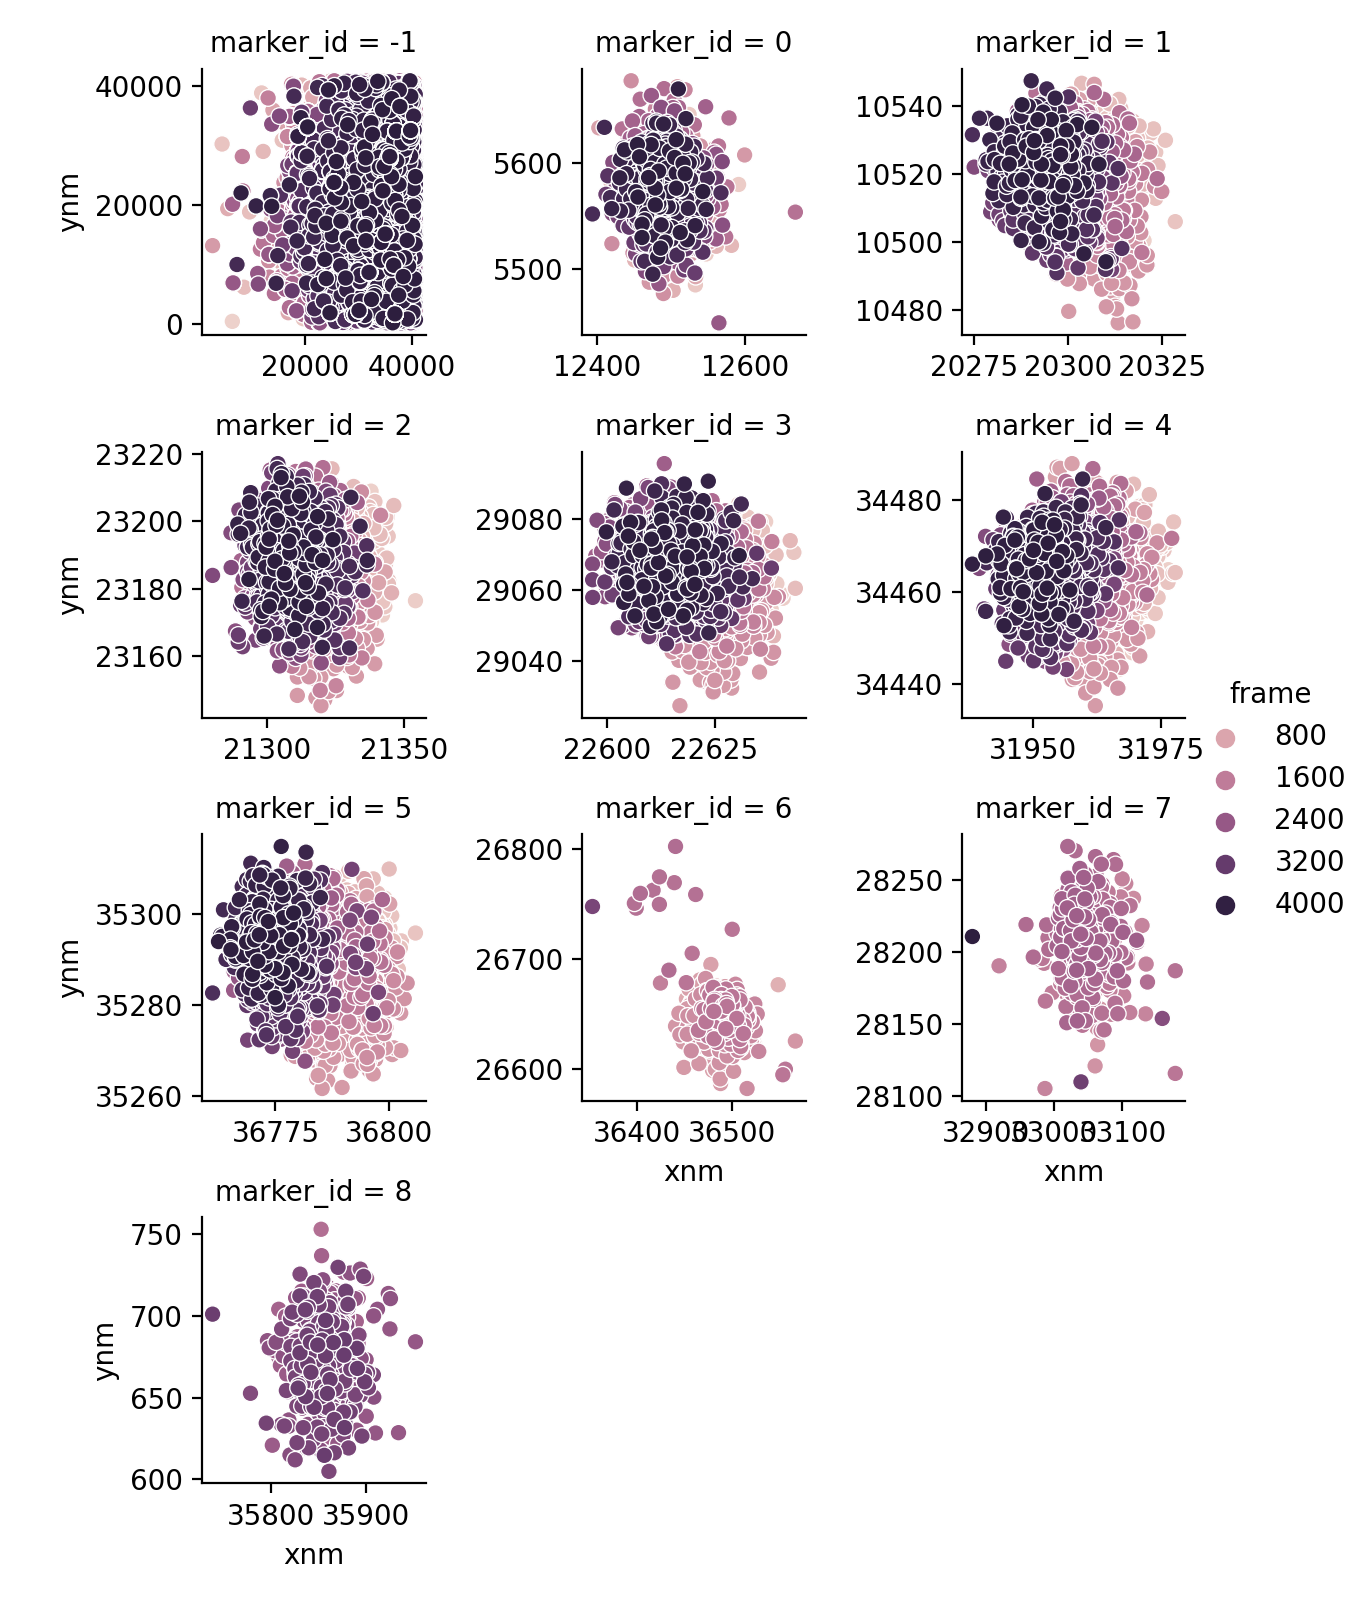

In [5]:
# Show the coordinates of all identified markers in the mVenus channel
sns.relplot(data=mVenus_beads, x="xnm", y="ynm", hue="frame", col="marker_id", col_wrap=3, height=2,
            facet_kws={'sharey': False, 'sharex': False})

# Show the coordinates of all identified markers in the PAmCherry channel
sns.relplot(data=PAmCherry_beads, x="xnm", y="ynm", hue="frame", col="marker_id", col_wrap=3, height=2,
            facet_kws={'sharey': False, 'sharex': False})


# In the mVenus channel: Apparently, in our example, we need to exclude marker_id = -1 which is basically
# just non-clustered localizations

# in the PAmCherry channel: In our example, we need to exclude marker_id = -1 which is basically
# just non-clustered localizations

<IPython.core.display.Javascript object>


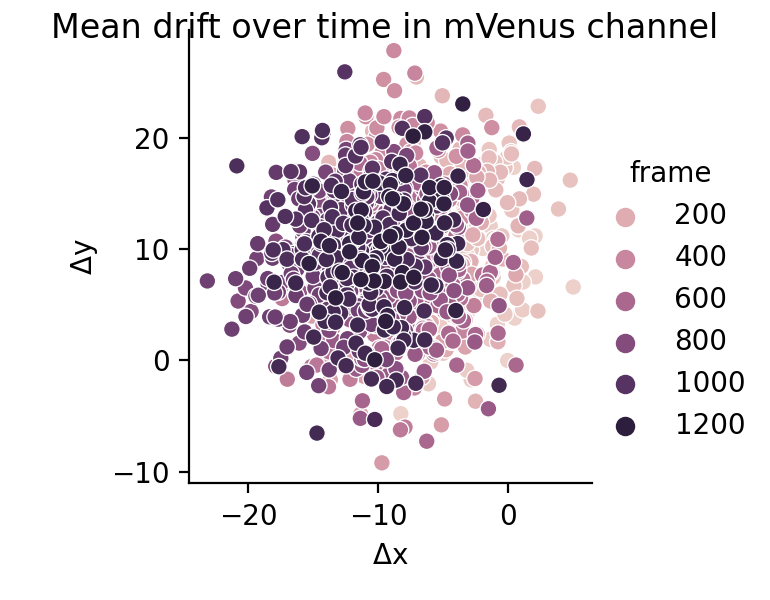

<IPython.core.display.Javascript object>


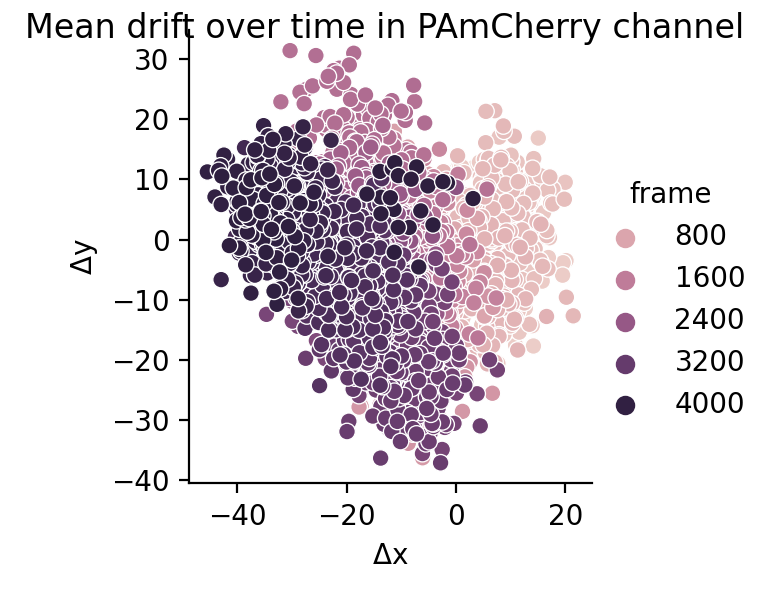

In [6]:
## Correct drift in the mVenus channel

ignore_marker = [-1] # Ignore these marker IDs for drift correction as determined above

# Extract the trajectories for all marker IDs except for those in ignore_marker
id_list = list(mVenus_beads.marker_id.unique()[np.isin(mVenus_beads.marker_id.unique(), 
                                                       ignore_marker, invert=True)])

# Extract the trajectories over time, the mean is also saved in the drift variable of the channel object
raw_data.channel["mVenus"].extract_drift(mVenus_beads, "marker_id", id_list=id_list)

# Plot the mean trajectory over time (as indicated by the number of frames)
g = sns.relplot(data = raw_data.channel["mVenus"].drift, x="delta_x", y="delta_y", kind="scatter", 
            hue="frame", height=3)
g.fig.suptitle("Mean drift over time in mVenus channel")
plt.xlabel("$\Delta$x")
plt.ylabel("$\Delta$y")
plt.show()



## Correct PAmCherry channel


ignore_marker = [-1] # Ignore these marker IDs for drift correction as determined above

# Extract the trajectories for all IDs except for those in ignore_marker
id_list = list(PAmCherry_beads.marker_id.unique()[np.isin(PAmCherry_beads.marker_id.unique(), 
                                                          ignore_marker, invert=True)])

# Extract the trajectories, the mean is also saved in the drift variable of the channel
raw_data.channel["mCherry"].extract_drift(PAmCherry_beads, "marker_id", id_list=id_list)

# Plot the mean trajectory
g = sns.relplot(data = raw_data.channel["mCherry"].drift, x="delta_x", y="delta_y", kind="scatter", 
            hue="frame", height=3)
g.fig.suptitle("Mean drift over time in PAmCherry channel")
plt.xlabel("$\Delta$x")
plt.ylabel("$\Delta$y")
plt.show()




In [7]:
# Correct the localizations in each channel using the markers identified previously
raw_data.channel["mVenus"].correct_drift()
raw_data.channel["mCherry"].correct_drift()

In [8]:
for channel in raw_data.channel:
    # Find all fluorescent protein clusters in the channels.
    # The intensity_threshold is set to 100 to exclude obvious artifacts.
    # The min_samples is set to a minimum of 3 samples per cluster. This needs to be adjusted for other fluorophores.
    # The eps is set to 100 nm as a maximum distance between localizations.
    # The localizations will be assigned to a specific cluster by putting an ID label in the "clusters" column.
    raw_data.channel[channel].find_clusters(intensity_threshold=100, min_samples=3, eps=100, save_column="clusters") 



<IPython.core.display.Javascript object>


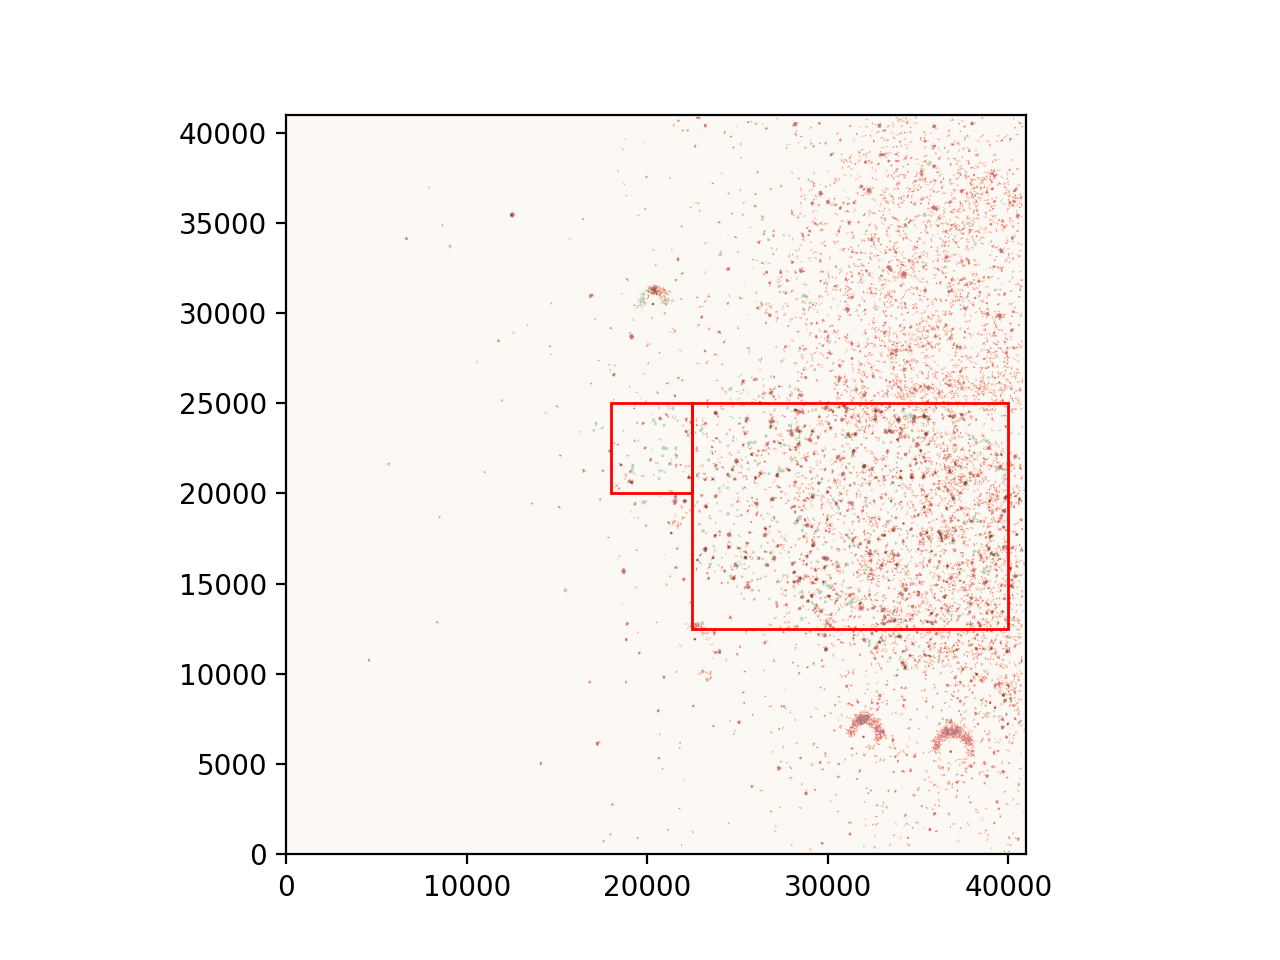

In [9]:
# Plot a reconstruction of the localizations that have been assigned to clusters.
# This excludes background signals.

# This defines a list of rectangular regions of interest (roi)
rois = [(22500, 12500, 17500, 12500), 
        (18000, 20000, 4500, 5000)]

# Display drift corrected image
plt.figure()
# Plot the clustered coordinates

imgplot = plt.imshow(raw_data.channel["mVenus"].generate_reconstruction(cluster_column="clusters"), cmap="Greens", 
                     alpha=0.5, extent=[0,40960,0,40960])
imgplot = plt.imshow(raw_data.channel["mCherry"].generate_reconstruction(cluster_column="clusters"), cmap="Reds", 
                     alpha=0.5, extent=[0,40960,0,40960])

# draw rois on top of the image
for roi in rois:
    rect = patches.Rectangle((roi[0], roi[1]), roi[2], roi[3], linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
plt.show()




In [10]:
# Calculate the colocalization ratio within the same rois as defined above.
coloc_ratio = raw_data.get_colocalization_ratio("mVenus", "mCherry", "clusters", distance_cutoff=100, rois=rois)
print(f"The colocalization ratio within the ROIs is {round(coloc_ratio, 5)}")

The colocalization ratio within the ROIs is 0.2962
